In [1]:
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm, notebook

# from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
# from transformers import AdamW
from transformers import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import (roc_auc_score,
                             average_precision_score,
                             accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             brier_score_loss, # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html
                             confusion_matrix,)
from imblearn.metrics import specificity_score

from model import *

SEED = 42
# random.seed(SEED) #  Python의 random 라이브러리가 제공하는 랜덤 연산이 항상 동일한 결과를 출력하게끔
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/home/jsy/anaconda3/envs/NIA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calc_acc(output, label):
    o_val, o_idx = torch.max(output, dim=-1)
    # l_val, l_idx = torch.max(label, dim=-1)
    return (o_idx == label).sum().item()

def set_device(device_num=0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        device += ':{}'.format(device_num)
    return device

In [3]:
def ROC_PRC_PLOT(FLAG, model_info, gpu=0, ):
    """
    gpu                     : device number
    FLAG                    : True=ROC Curve, False=PRC Curve
    model_info = [
        pred_path           : prediction을 저장한 csv파일 경로
        model_name          : 모델 이름
        plot_label          : legend에 표시될 명칭
        threshold           : recall 0.75가되는 label_frequency
        color               : 색깔 (C1 ~ CN)
    ]
    """
    # args
    device = set_device(device_num=gpu)
    
    for pred_path, model_name, plot_label, threshold, color in model_info:
        prediction_df = pd.read_csv(pred_path)

        labels = prediction_df.labels
        predicted_probas = prediction_df.predicted_probas

        fpr, tpr, thresholds = roc_curve(labels, predicted_probas)
        precision, recall, _ = precision_recall_curve(labels, predicted_probas)
        
        if FLAG :
            ## AUROC        
            plt.plot(fpr, tpr, linestyle='--', linewidth=2.0, label=plot_label, color=color)
        else:
            ## AUPRC
            plt.plot(recall, precision, linestyle='--', linewidth=2.0, label=plot_label, color=color)
            
    if FLAG : 
        ## AUROC 
        no_skill = np.sum(labels == 1)/len(labels)
        y_pred_ns = [0 for _ in range(len(labels))]
        fpr_ns, tpr_ns, thresholds_ns = roc_curve(labels, y_pred_ns)
        plt.plot(fpr_ns, tpr_ns, linestyle='--', linewidth=1.5, label='No Skill', color='black')
        
        # axis labels
        plt.xlabel('False Positive Rate', fontsize = 16)
        plt.ylabel('True Positive Rate', fontsize = 16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim([0.,1.])
        plt.xlim([0.,1.])

        # show the legend
        plt.grid()
        plt.legend(loc = 'lower right', fontsize=13)
        plt.title(f"AUROC ", fontsize = 16)
        plt.savefig(os.path.join('plotting', 'auroc_curve.png'), 
                    dpi=300)
        plt.show()
        plt.close()
    else:
        ## AUPRC
        no_skill = np.sum(labels == 1)/len(labels)
        plt.plot([0,1], [no_skill, no_skill], linestyle = '--', linewidth = 1.5, label='No Skill', color = 'black')
        
        plt.xlabel('Recall', fontsize = 16)
        plt.ylabel('Precision', fontsize = 16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim([-0.00, 1.00])
        plt.xlim([-0.00,1.00])
            #show the legned
        plt.grid()
        plt.legend(fontsize=13)

        plt.title(f'Precision-Recall iteration', fontsize = 16)
        plt.savefig(os.path.join('plotting', 'precision_recall_curve.png')
                    , dpi=300)
        plt.show()
        plt.close()

# Primary Outcome

In [4]:
model_info = [(os.path.join('models', 'only_Text_GPT_MULTI_1_e10_bs12', 'inference_logit_checkpoint_8_710_None_3.csv'), 
               '3way-default', '3way-default', 0.0528, 'C2'),
              (os.path.join('models', 'only_Text_GPT_MULTI_1_e10_bs12', 'inference_logit_checkpoint_8_710_moving_average_3.csv'), 
               '3way-mv_avg(3)', '3way-mv_avg(3)', 0.0509, 'C3'),
              ]
gpu = 0
LABEL_TYPE = True

## ROC Plot

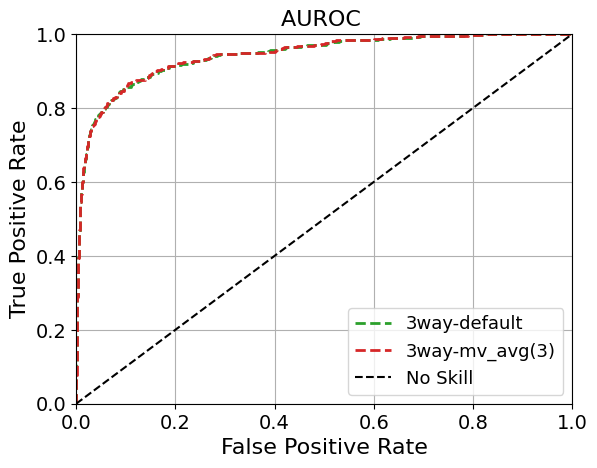

In [5]:
ROC_PRC_PLOT(FLAG=True, gpu=gpu, model_info=model_info)

## PRC Plot

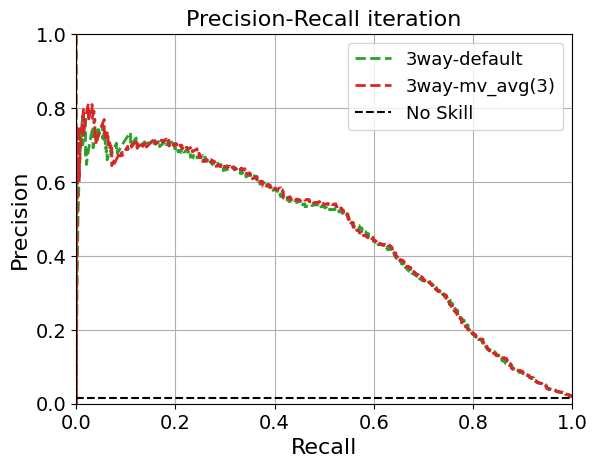

In [6]:
ROC_PRC_PLOT(FLAG=False, gpu=gpu, model_info=model_info)

In [7]:
K = 10
sample_rate = 0.75

df_list = [
    [os.path.join('models', 'only_Text_GPT_MULTI_1_e10_bs12', 'inference_logit_checkpoint_8_710_None_3.csv'), '3way-default', 0.0528],
    [os.path.join('models', 'only_Text_GPT_MULTI_1_e10_bs12', 'inference_logit_checkpoint_8_710_moving_average_3.csv'), '3way-mv_avg(3)', 0.0509]
]


RESULT = {
    'MODEL': [],
    'ACC' : [],
    'AUROC' : [], 
    'AUPRC' : [], 
    'RECALL' : [], 
    'PRECISION' : [],
    'SPECIFICITY' : [],
    'F1' : [], 
    'BRIER' : [],
}
for df_path, name, threshold in df_list:
    df = pd.read_csv(df_path)
    
    df['predicted_labels'] = np.where(df.predicted_probas >= threshold, 1, 0)
    METRIC_DICT = {
        'ACC' : [],
        'AUROC' : [], 
        'AUPRC' : [], 
        'RECALL' : [], 
        'PRECISION' : [],
        'SPECIFICITY' : [],
        'F1' : [], 
        'BRIER' : [],}
    for k in range(K):
        bootstrap_data = df.sample(frac=sample_rate, random_state=SEED+k)
        bootstrap_data = bootstrap_data.reset_index(drop=True)
        

        predicted_labels = bootstrap_data.predicted_labels
        predicted_probas = bootstrap_data.predicted_probas
        labels = bootstrap_data.labels
        
        ACC = accuracy_score(labels, predicted_labels)
        AUROC = roc_auc_score(labels, predicted_probas)
        AUPRC = average_precision_score(labels, predicted_probas)
        RECALL = recall_score(labels, predicted_labels)
        PRECISION = precision_score(labels, predicted_labels)
        SPECIFICITY = specificity_score(labels, predicted_labels)
        F1 = f1_score(labels, predicted_labels)
        BRIER = brier_score_loss(labels, predicted_probas)
        
        METRIC_DICT['ACC'].append(ACC)
        METRIC_DICT['AUROC'].append(AUROC)
        METRIC_DICT['AUPRC'].append(AUPRC)
        METRIC_DICT['RECALL'].append(RECALL)
        METRIC_DICT['PRECISION'].append(PRECISION)
        METRIC_DICT['SPECIFICITY'].append(SPECIFICITY)
        METRIC_DICT['F1'].append(F1)
        METRIC_DICT['BRIER'].append(BRIER)

    RESULT['MODEL'].append(name)
    for k in METRIC_DICT.keys():
        mean = np.round(np.mean(METRIC_DICT[k]), 3)
        std = np.round(np.std(METRIC_DICT[k]), 3)
            
        RESULT[k].append(f"{mean}±{std}")
        
model_result_df = pd.DataFrame(RESULT)
model_result_df.to_csv(os.path.join('plotting', 'result.csv'), index=0)
model_result_df

,MODEL,ACC,AUROC,AUPRC,RECALL,PRECISION,SPECIFICITY,F1,BRIER
0,3way-default,0.963±0.001,0.944±0.002,0.449±0.016,0.755±0.011,0.275±0.005,0.967±0.001,0.404±0.006,0.012±0.0
1,3way-mv_avg(3),0.963±0.001,0.945±0.002,0.453±0.016,0.75±0.011,0.275±0.005,0.967±0.0,0.402±0.006,0.012±0.0
